In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=15

In [74]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\nitin\OneDrive\Desktop\MiniProject\Dataset1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1378 files belonging to 2 classes.


In [75]:
len(dataset)

44

In [76]:
class_name = dataset.class_names
class_name

['Gun', 'Knife']

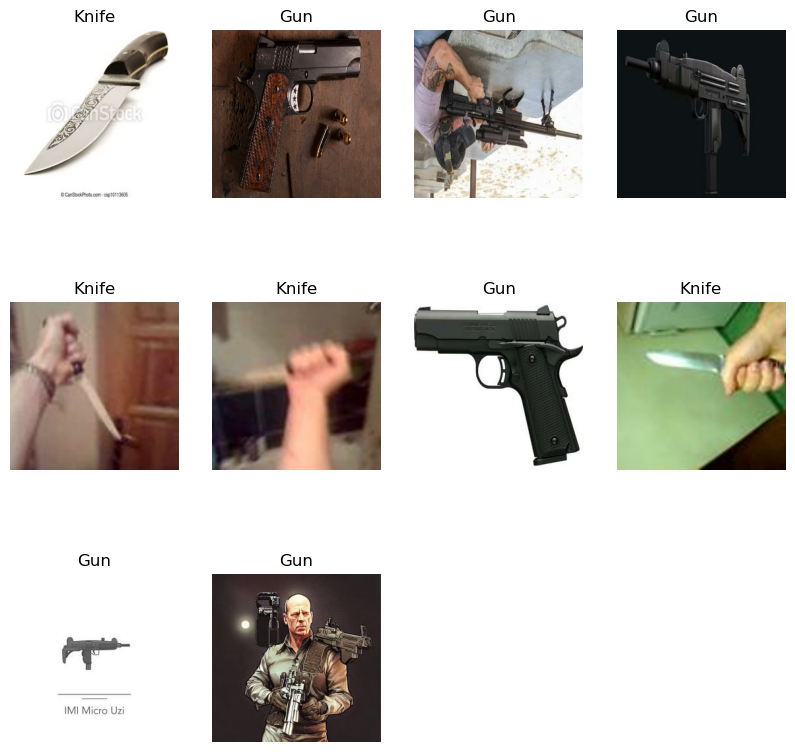

In [77]:
# Data Visualization.

plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [78]:
import os

In [79]:
# 80% ==> Tranining
# 20% ==> 10% Validation , 10% Test

train_size = 0.8
int(len(dataset)*train_size)

35

In [80]:
# spliting data for training
train_ds = dataset.take(35)
len(train_ds)

35

In [81]:
# Skiping training data that will give test data

test_ds = dataset.skip(35)
len(test_ds)

9

In [82]:
# validation size is 0.1(10%)
val_size = 0.1
int(len(dataset)*val_size)
# no. of photos for validation per Batch or EPOCH

4

In [83]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [84]:
test_ds = test_ds.skip(4)
len(test_ds)

5

In [85]:
# this function performs above task ( splits dataset into training , testing and validation)
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [86]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [87]:
len(train_ds)

26

In [88]:
len(val_ds)

8

In [89]:

len(test_ds)

10

## Cache, Shuffle, and Prefetch the Dataset

In [90]:
# cashing -> it will read the image form the disk and then for the next iteration when you need the same image it will keep that image in memory
            #this improves the performance of pipeine
# shuffle -> shuffle the images
# prefatch -> if you are using gpu and cpu if gpu is busy in training prefatch will load the next set of batch from the disk that will improve the performance
# Autotune -> tensorflow determines how many batches to load while GPU is training

# due to this training will Fast 

In [91]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [92]:
#  Model Builiding

# converting image from RGB to gray scale and then changing the resolution of the image to 256 * 256

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])


In [93]:
# Data Augmentation
# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [94]:
# if the image is rotated or different in contrast then your model will not perfrom better so we using data augmentation

# data augmentation => to identify  unknown entry like rotated image , different conrast, verticalllyn rotated, horizontally flippped

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [95]:
#
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [96]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 7

# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Flatten())

#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(7, activation='softmax'))

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [97]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [98]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [99]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/15
26/26 [==============================] - 28s 907ms/step - loss: 0.8289 - accuracy: 0.6526 - val_loss: 0.4850 - val_accuracy: 0.7070
Epoch 2/15
26/26 [==============================] - 22s 842ms/step - loss: 0.4615 - accuracy: 0.7512 - val_loss: 0.4640 - val_accuracy: 0.7891
Epoch 3/15
26/26 [==============================] - 22s 843ms/step - loss: 0.3492 - accuracy: 0.8786 - val_loss: 0.1354 - val_accuracy: 0.9531
Epoch 4/15
26/26 [==============================] - 23s 857ms/step - loss: 0.2158 - accuracy: 0.9303 - val_loss: 0.1434 - val_accuracy: 0.9492
Epoch 5/15
26/26 [==============================] - 23s 860ms/step - loss: 0.2098 - accuracy: 0.9423 - val_loss: 0.1056 - val_accuracy: 0.9648
Epoch 6/15
26/26 [==============================] - 22s 858ms/step - loss: 0.1701 - accuracy: 0.9531 - val_loss: 0.1020 - val_accuracy: 0.9727
Epoch 7/15
26/26 [==============================] - 23s 858ms/step - loss: 0.1655 - accuracy: 0.9483 - val_loss: 0.1747 - val_accuracy: 0.9648

In [100]:
scores=model.evaluate(test_ds)

10/10 [==============================] - 5s 174ms/step - loss: 0.2118 - accuracy: 0.9406


In [101]:
scores

[0.21177849173545837, 0.940625011920929]

In [102]:
history
history.params
history.history['accuracy']

[0.6526442170143127,
 0.7512019276618958,
 0.8786057829856873,
 0.9302884340286255,
 0.942307710647583,
 0.953125,
 0.948317289352417,
 0.9519230723381042,
 0.9507211446762085,
 0.9254807829856873,
 0.9507211446762085,
 0.9651442170143127,
 0.9507211446762085,
 0.953125,
 0.9567307829856873]

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

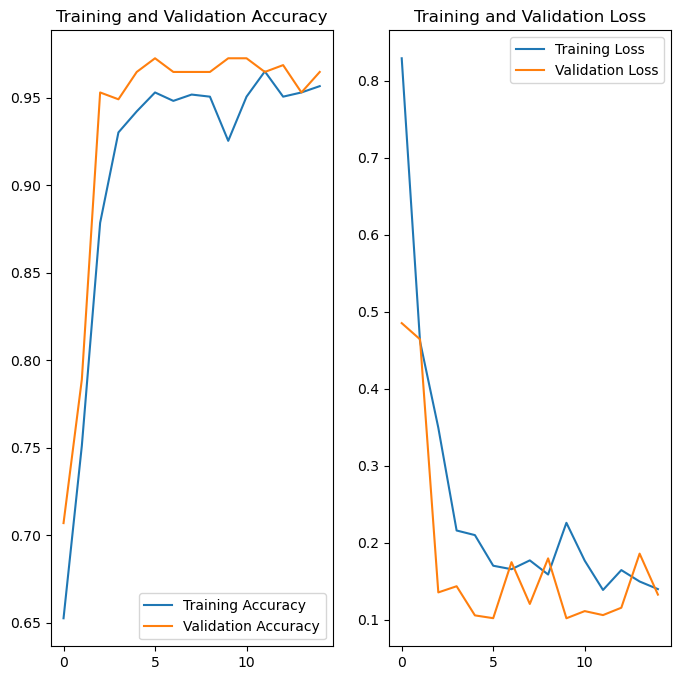

In [104]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first images's actual label: Gun
1/1 [==============================] - 0s 399ms/step
predicted label: Gun


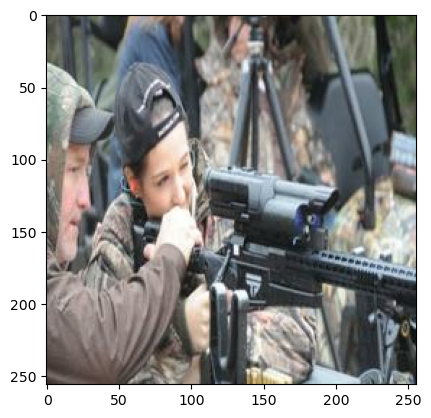

In [105]:
#predicting class of image
#we are doing shuffling hence image is/are changing
for images_batch,labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first images's actual label:",class_name[first_label])
    
    batch_prediction= model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [106]:
#for batch data predictions
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #to create batch
    
    predictions = model.predict(img_array)
    
    
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 39ms/step


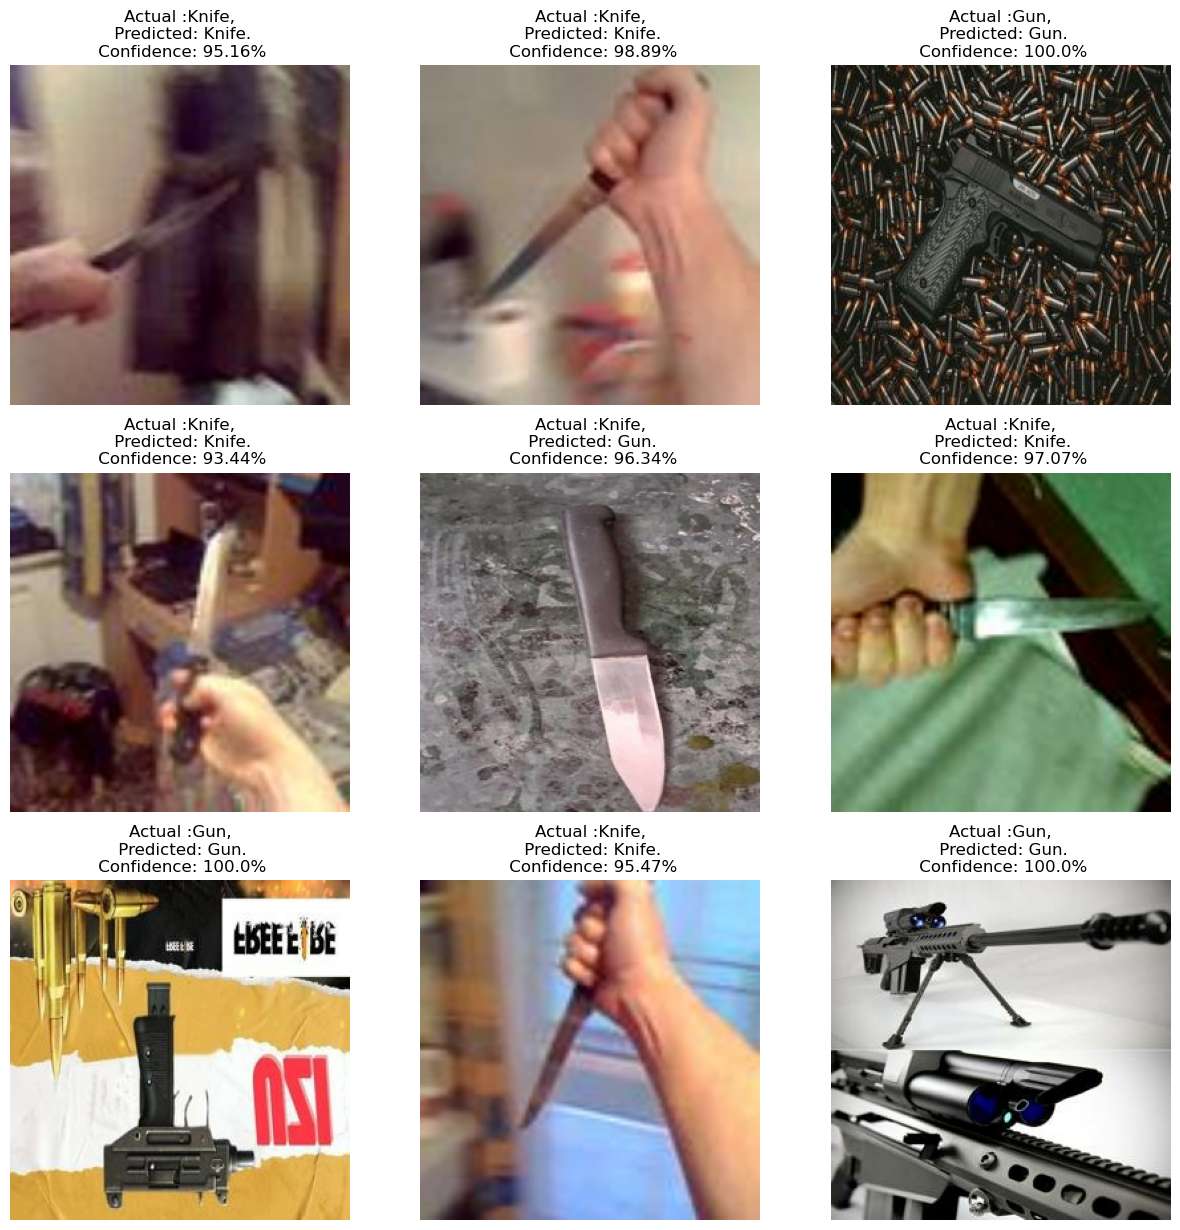

In [108]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class = class_name[labels[i]]
        plt.title(f"Actual :{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")